# Jay Reagan's Pricing Presentation

Note: this notebook was written to accompany a presentation I gave at a data science meetup.


Assignment: diamonds.txt is a modified Kaggle.com dataset that can be used to analyze diamonds by their price, cut, color, and other attributes. The original dataset's "carat" feature has been removed. 

Goal: Engineer at least one feature and build a model that will predict price for new data points.


Data is in a tab delimited text file with header and 40,000 records of “round” diamonds. The data has the following features: 

Price: in US dollars

Cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

Color: diamond color, from J (worst) to D (best)

Clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

Depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y)

Table: width of top of diamond relative to widest point

X: length in mm 

Y: width in mm 

Z: depth in mm 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

As a first step, let's load diamonds.txt into a pandas dataframe. Taking a quick look at the head of the dataframe will help verify that the dataset was transferred correctly.

In [2]:
df = pd.read_csv('diamonds.txt', sep="\t")
df.head()

,price,cut,color,clarity,depth,table,x,y,z
0,326,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,327,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,334,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [3]:
df.head()

,price,cut,color,clarity,depth,table,x,y,z
0,326,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,327,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,334,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


As a second preliminary step, we should get a summary of the data. This will help us understand the data, and also identify any potential problems such as missing or obviously incorrect values. 

In [4]:
df.describe()

,price,depth,table,x,y,z
count,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000
mean,3927.016125,61.753705,57.46084,5.729185,5.731744,3.538132
std,3982.226472,1.430005,2.23462,1.121125,1.120159,0.709047
min,326.000000,43.000000,43.00000,0.000000,0.000000,0.000000
25%,949.000000,61.000000,56.00000,4.710000,4.720000,2.910000
50%,2401.000000,61.800000,57.00000,5.700000,5.710000,3.520000
75%,5313.250000,62.500000,59.00000,6.540000,6.540000,4.032500
max,18823.000000,79.000000,95.00000,10.140000,31.800000,31.800000


In [5]:
nan_count = len(df) - df.count()
print(nan_count)

price      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64


It appears that the dataframe contains 40000 entries and does not have any NaN entries. However, it does seem that some diamonds have an x, y, or z measurement of 0, which is clearly not possible. Let's count how many rows have this problem.

In [6]:
print((df.x == 0).sum())
print((df.y == 0).sum())
print((df.z == 0).sum())

7
6
15


Since so few entries have 0 measurements, let's just drop them from the dataframe. Then we will take another look at the dataframe's summary to ensure the problem has been solved.

In [7]:
df = df[df.x != 0]
df = df[df.y != 0]
df = df[df.z != 0]
df.describe()

,price,depth,table,x,y,z
count,39985.000000,39985.000000,39985.000000,39985.000000,39985.000000,39985.000000
mean,3925.179517,61.753820,57.460538,5.729820,5.732228,3.539459
std,3980.190804,1.429706,2.233961,1.118407,1.117817,0.705860
min,326.000000,43.000000,43.000000,3.730000,3.710000,1.070000
25%,949.000000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2400.000000,61.800000,57.000000,5.700000,5.710000,3.530000
75%,5312.000000,62.500000,59.000000,6.540000,6.540000,4.040000
max,18823.000000,79.000000,95.000000,10.140000,31.800000,31.800000


Everything looks fine so far. Since our dataset is non-continuous in the cut, color, and clarity columns, we will need to one-hot encode before we can create a model. However, before we do that, let's take a quick look at the correlation heatmap of the data. This will help us to identify which non-categorical features are most correlated with price.

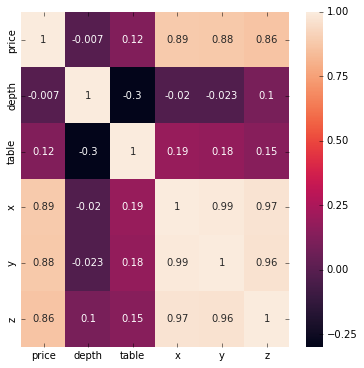

In [13]:
plt.figure(figsize = (6,6))
sns.heatmap(df.corr(), annot=True)

The x, y, and z features are highly correlated with price. Also, the table and depth features do not appear to be well-correlated with price. Since engineering a new feature is required, we should also look at correlations between other features. It appears that x, y, and z correlate well with each other, so perhaps some measure of volume would be appropriate. We cannot calculate the exact volume of a round diamond with the information provided, but as the three measurements are so well correlated, a cubic volume measure could be useful. Let's add it to the dataframe.

,price,cut,color,clarity,depth,table,x,y,z,vol
0,326,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,38.202030
1,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,34.505856
2,327,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,38.076885
3,334,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,46.724580
4,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,51.917250


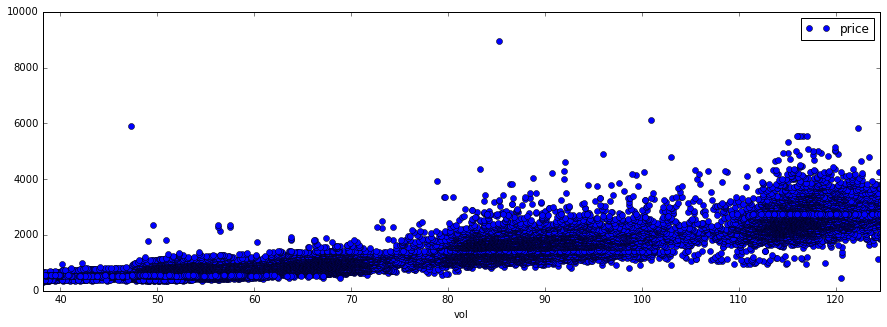

In [16]:
df['vol'] = df['x'] * df['y'] * df['z']
df.plot(x='vol', y='price', style='o', figsize=(15,5), ylim = (0,10000))
df.head()

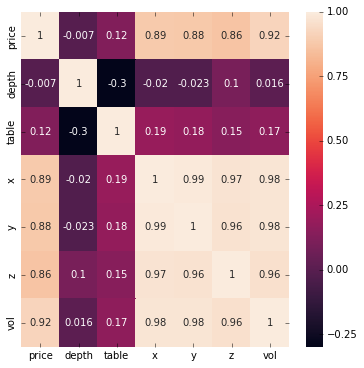

In [17]:
plt.figure(figsize = (6,6))
sns.heatmap(df.corr(), annot=True)

Indeed, increased volume appears to lead to increased diamond price. In fact, volume is more highly correlated with price than any of x, y, and z. Next, we should encode the categorical features as a one-hot numeric array. 

In [18]:
df =  pd.get_dummies(df)
df.head()

,price,depth,table,x,y,z,vol,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,326,61.5,55.0,3.95,3.98,2.43,38.202030,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,326,59.8,61.0,3.89,3.84,2.31,34.505856,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,327,56.9,65.0,4.05,4.07,2.31,38.076885,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,334,62.4,58.0,4.20,4.23,2.63,46.724580,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,335,63.3,58.0,4.34,4.35,2.75,51.917250,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


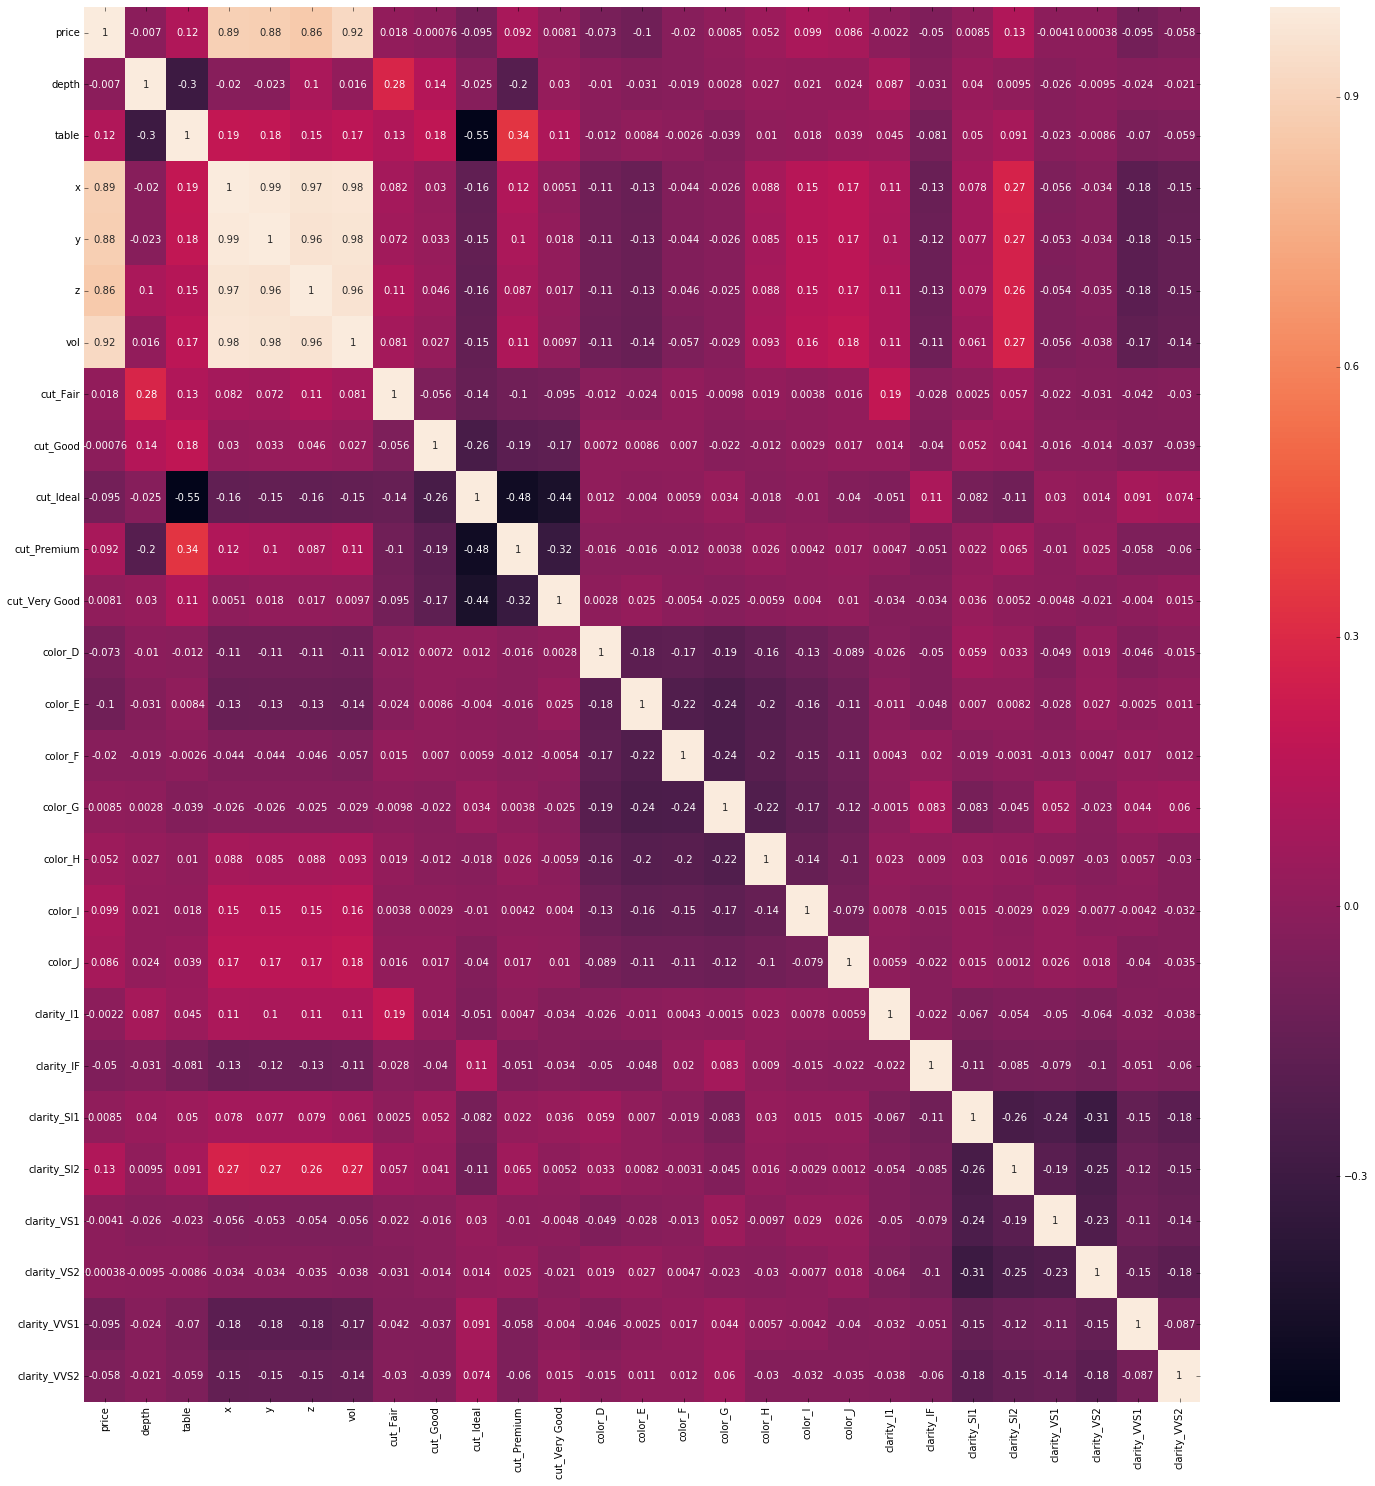

In [19]:
plt.figure(figsize = (25,25))
p=sns.heatmap(df.corr(), annot=True)

Note that while the categorical data is not highly correlated to anything in particular, it does contain some useful connections (such as SI2 clarity being somewhat correlated to x, y, z, and volume). Now, let's get ready to train/test a model. We will also standardize the data. 

In [56]:
x = df.drop(["price"], axis=1)
y = df.price

In [57]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2)

In [58]:
scaler = preprocessing.StandardScaler().fit(train_x)
scaler.transform(train_x)
scaler.transform(test_x)

array([[ 0.45199578,  0.24201217,  1.16915442, ..., -0.54222961,
        -0.27202842, -0.32235074],
       [-0.24901615, -0.20385401, -0.78622088, ..., -0.54222961,
         3.67608645, -0.32235074],
       [-0.24901615, -0.20385401, -0.84003855, ..., -0.54222961,
        -0.27202842, -0.32235074],
       ...,
       [ 0.52209698,  0.24201217,  0.37982861, ..., -0.54222961,
        -0.27202842, -0.32235074],
       [-0.17891495, -1.54145253, -1.13603572, ..., -0.54222961,
        -0.27202842, -0.32235074],
       [-0.24901615, -1.54145253,  2.78368448, ..., -0.54222961,
        -0.27202842, -0.32235074]])

I will begin with a simple linear regression. Although linear regression may not always produce the most accurate result, it is interpretable and relatively easy to explain to non-technical audiences. Thus, depending on the model's audience, linear regression could be preferable to more robust models. 

In [59]:
lr = linear_model.LinearRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)

print("Training Accuracy:")
print(lr.score(train_x, train_y))
print("Testing Accuracy:")
print(lr.score(test_x, test_y))
print("MSE of:")
print(mean_squared_error(test_y, predictions))

Training Accuracy:
0.9206951085194607
Testing Accuracy:
0.9271933868949092
MSE of:
1188797.9819591283


The model has a testing accuracy of 92.7%. For comparision, let's see how accurate linear regression is without the engineered volume feature.

In [17]:
train_x_2 = train_x.drop('vol', axis=1)
test_x_2 = test_x.drop('vol', axis=1)
train_y_2 = train_y
test_y_2 = test_y

In [18]:
train_x_2 = train_x.drop('vol', axis=1)
test_x_2 = test_x.drop('vol', axis=1)

lr_2 = linear_model.LinearRegression()
lr_2.fit(train_x_2, train_y_2)
predictions_2 = lr_2.predict(test_x_2)

print("Training Accurary:")
print(lr_2.score(train_x_2, train_y_2))
print("Testing Accuracy:")
print(lr_2.score(test_x_2, test_y_2))
print("MSE of:")
print(mean_squared_error(test_y_2, predictions_2))

Training Accurary:
0.8451944001970164
Testing Accuracy:
0.8491988194743979
MSE of:
2510166.6137029473


Without the volume feature, linear regression is only 84.9% accurate, which is a significant difference. This illustrates a key point of our assignment: feature engineering can be very helpful, especially when working with simple models.

After testing a few other basic models, I found that Gradient Boosting produces a relatively accurate model. I use RandomizedSearchCV to do a randomized search on parameters. 

In [2]:
gb = GradientBoostingRegressor(n_estimators = 500)
params = {"learning_rate": np.linspace(0.05, 0.15, 5), "max_depth": range(3, 5), "min_samples_leaf": range(3, 5)}

search = RandomizedSearchCV(gb, params, n_iter = 5)
search.fit(train_x, train_y)
search.grid_scores_

print(search.best_params_)

The search returns learning_rate  = 0.125, max_depth = 4, and min_samples_leaf = 3 as good parameters.

In [20]:
gb = GradientBoostingRegressor(n_estimators = 500, learning_rate= 0.125,
                               max_depth= 4, min_samples_leaf = 3)
gb.fit(train_x, train_y)
predictions_3 = gb.predict(test_x)

print('Training Accuracy:')
print(gb.score(train_x, train_y))
print('Testing Accuaracy:')
print(gb.score(test_x, test_y))
print("MSE:")
print(mean_squared_error(test_y, predictions_3))

Training Accuracy:
0.9886792305891495
Testing Accuaracy:
0.9800966899416008
MSE:
331301.281837709


Gradient Boosting gives a testing accuracy of 98%. Again, let's compare to with the original dataset without the new feature:

In [21]:
gb_2 = GradientBoostingRegressor(n_estimators = 500)
params_2 = {"learning_rate": np.linspace(0.05, 0.15, 5), "max_depth": range(3, 5), "min_samples_leaf": range(3, 5)}

search = RandomizedSearchCV(gb_2, params_2, n_iter = 5)
search.fit(train_x_2, train_y_2)
search.grid_scores_

print(search.best_params_)

{'learning_rate': 0.15, 'max_depth': 4, 'min_samples_leaf': 4}


In [22]:
gb_2 = GradientBoostingRegressor(n_estimators = 500, learning_rate= 0.15,
                                 max_depth= 4, min_samples_leaf = 4)

gb_2.fit(train_x_2, train_y_2)
predictions_4 = gb_2.predict(test_x_2)

print('Training Accuracy:')
print(gb_2.score(train_x_2, train_y_2))
print('Testing Accuaracy:')
print(gb_2.score(test_x_2, test_y_2))
print("MSE:")
print(mean_squared_error(test_y_2, predictions_4))

Training Accuracy:
0.9884844538585075
Testing Accuaracy:
0.980430151855053
MSE:
325750.62925546936


Since Gradient Boosting is much more robust than standard linear regression, adding the volume feature did not significantly impact accuracy.

For an even more accurate model, one may want to try advanced tools from deep learning or quantitative finance (along with more data).